In [5]:
# =========================================
# 1. Setup & Data Import
# =========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Load dataset
df = pd.read_csv('udemy_online_education_courses_dataset.csv')  # Replace with your dataset path
print("Dataset Shape:", df.shape)
display(df.head())

Dataset Shape: (3678, 12)


,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
0,1070968,Ultimate Investment Banking Course,https://www.udemy.com/ultimate-investment-bank...,True,200,2147,23,51,All Levels,1.5,2017-01-18T20:58:58Z,Business Finance
1,1113822,Complete GST Course & Certification - Grow You...,https://www.udemy.com/goods-and-services-tax/,True,75,2792,923,274,All Levels,39.0,2017-03-09T16:34:20Z,Business Finance
2,1006314,Financial Modeling for Business Analysts and C...,https://www.udemy.com/financial-modeling-for-b...,True,45,2174,74,51,Intermediate Level,2.5,2016-12-19T19:26:30Z,Business Finance
3,1210588,Beginner to Pro - Financial Analysis in Excel ...,https://www.udemy.com/complete-excel-finance-c...,True,95,2451,11,36,All Levels,3.0,2017-05-30T20:07:24Z,Business Finance
4,1011058,How To Maximize Your Profits Trading Options,https://www.udemy.com/how-to-maximize-your-pro...,True,200,1276,45,26,Intermediate Level,2.0,2016-12-13T14:57:18Z,Business Finance


In [11]:
df.isnull().sum()

course_id              0
course_title           0
url                    0
is_paid                0
price                  0
num_subscribers        0
num_reviews            0
num_lectures           0
level                  0
content_duration       0
published_timestamp    0
subject                0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3678 entries, 0 to 3677
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   course_id            3678 non-null   int64  
 1   course_title         3678 non-null   object 
 2   url                  3678 non-null   object 
 3   is_paid              3678 non-null   bool   
 4   price                3678 non-null   int64  
 5   num_subscribers      3678 non-null   int64  
 6   num_reviews          3678 non-null   int64  
 7   num_lectures         3678 non-null   int64  
 8   level                3678 non-null   object 
 9   content_duration     3678 non-null   float64
 10  published_timestamp  3678 non-null   object 
 11  subject              3678 non-null   object 
dtypes: bool(1), float64(1), int64(5), object(5)
memory usage: 319.8+ KB


In [15]:
df.shape

(3678, 12)

In [17]:
df.describe()

,course_id,price,num_subscribers,num_reviews,num_lectures,content_duration
count,3.678000e+03,3678.000000,3678.000000,3678.000000,3678.000000,3678.000000
mean,6.759720e+05,66.049483,3197.150625,156.259108,40.108755,4.094517
std,3.432732e+05,61.005755,9504.117010,935.452044,50.383346,6.053840
min,8.324000e+03,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.076925e+05,20.000000,111.000000,4.000000,15.000000,1.000000
50%,6.879170e+05,45.000000,911.500000,18.000000,25.000000,2.000000
75%,9.613555e+05,95.000000,2546.000000,67.000000,45.750000,4.500000
max,1.282064e+06,200.000000,268923.000000,27445.000000,779.000000,78.500000


In [19]:
df = df.dropna(subset=['course_title', 'subject', 'level'])
df['level'] = df['level'].str.strip().replace({'Beginner Level':'Beginner','Intermediate Level':'Intermediate','Expert Level':'Expert'})

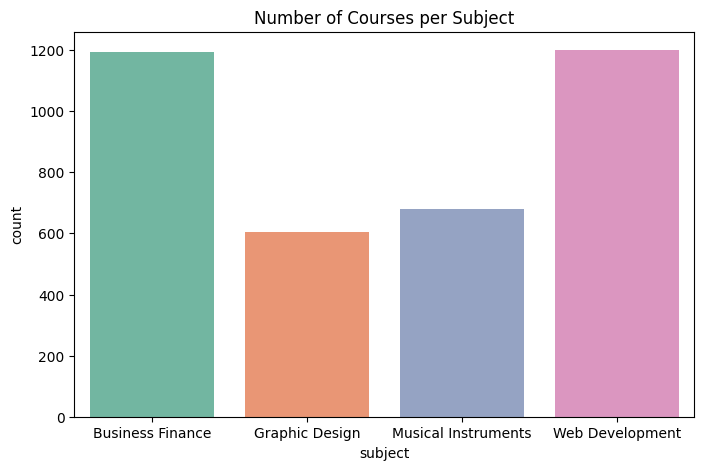

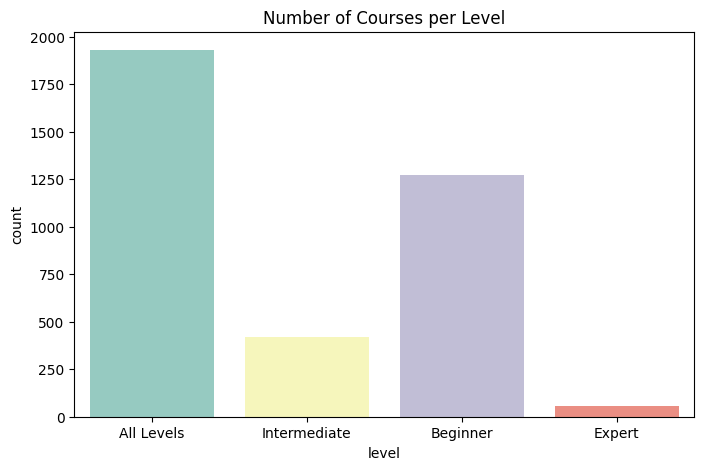

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.countplot(x='subject', data=df, palette='Set2')
plt.title("Number of Courses per Subject")
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(x='level', data=df, palette='Set3')
plt.title("Number of Courses per Level")
plt.show()

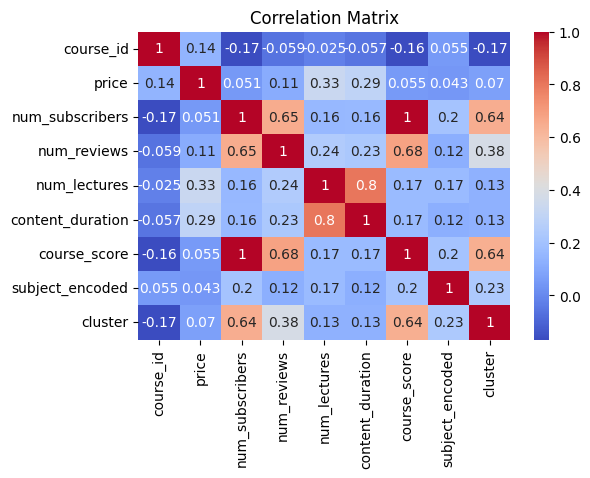

In [33]:
# Correlation heatmap (numeric columns only)
numeric_df = df.select_dtypes(include=np.number)
plt.figure(figsize=(6, 4))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [35]:
# =========================================
# 4. Feature Engineering
# =========================================
# Create a 'course_score' metric
df['course_score'] = (
    df['num_subscribers']*0.5 +
    df['num_reviews']*0.3 +
    df['content_duration']*0.2
)

# Encode subject as numeric for clustering
le = LabelEncoder()
df['subject_encoded'] = le.fit_transform(df['subject'])

In [37]:
# =========================================
# 5. Clustering with KMeans
# =========================================
features = df[['course_score', 'price', 'content_duration']]

# Determine optimal k via Silhouette Score
sil_scores = {}
for k in range(2, 7):
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    preds = kmeans_test.fit_predict(features)
    sil = silhouette_score(features, preds)
    sil_scores[k] = sil

optimal_k = max(sil_scores, key=sil_scores.get)
print("Optimal K:", optimal_k)

# Final clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

Optimal K: 2


In [39]:
# =========================================
# 6. Content-Based Filtering with TF-IDF
# =========================================
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['course_title'])
cos_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to recommend similar courses
def recommend_courses(course_title, num_recommendations=5):
    if course_title not in df['course_title'].values:
        return "Course not found in dataset"
    idx = df[df['course_title'] == course_title].index[0]
    sim_scores = list(enumerate(cos_sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:num_recommendations+1]
    course_indices = [i[0] for i in sim_scores]
    return df.iloc[course_indices][['course_title', 'subject', 'level']]

# Example test
print("\nRecommendations for a sample course:")
display(recommend_courses(df['course_title'].iloc[0]))


Recommendations for a sample course:


,course_title,subject,level
39,The Complete Investment Banking Course 2017,Business Finance,All Levels
240,Advanced Accounting for Investment Banking,Business Finance,Intermediate
417,The Investment Banking Recruitment Series,Business Finance,All Levels
3474,The Ultimate jQuery Course,Web Development,All Levels
2714,The Ultimate Web Development Course,Web Development,All Levels


In [41]:
# =========================================
# 7. Learning Path Sequencing
# =========================================
def get_learning_path(subject):
    subject_courses = df[df['subject'] == subject]
    subject_courses['level'] = pd.Categorical(subject_courses['level'], 
                                              categories=['Beginner', 'Intermediate', 'Expert'], 
                                              ordered=True)
    path = subject_courses.sort_values('level')[['course_title', 'level', 'subject']]
    return path.reset_index(drop=True)

# Example: Get a learning path for 'Web Development'
print("\nSample Learning Path for Web Development:")
display(get_learning_path("Web Development"))


Sample Learning Path for Web Development:


,course_title,level,subject
0,Web Design Creating websites from scratch,Beginner,Web Development
1,"Basic Concepts of Web Development, HTTP and Ja...",Beginner,Web Development
2,Dive Into Docker: The Docker Course for Develo...,Beginner,Web Development
3,Building Data Visualizations with D3 and Angul...,Beginner,Web Development
4,ExpressJS Fundamentals,Beginner,Web Development
...,...,...,...
1195,Learn Grunt with Examples: Automate Your Front...,NaN,Web Development
1196,jQuery UI in Action: Build 5 jQuery UI Projects,NaN,Web Development
1197,Learn jQuery from Scratch - Master of JavaScri...,NaN,Web Development
1198,Learn and Build using Polymer,NaN,Web Development


In [43]:
# =========================================
# 8. Insights & Conclusions
# =========================================
print("\nTop 5 Most Popular Courses:")
display(df.sort_values(by='num_subscribers', ascending=False)
          [['course_title', 'subject', 'num_subscribers']].head())

print("\nCluster Counts:")
print(df['cluster'].value_counts())


Top 5 Most Popular Courses:


,course_title,subject,num_subscribers
2827,Learn HTML5 Programming From Scratch,Web Development,268923
3032,Coding for Entrepreneurs Basic,Web Development,161029
3230,The Web Developer Bootcamp,Web Development,121584
2783,Build Your First Website in 1 Week with HTML5 ...,Web Development,120291
3232,The Complete Web Developer Course 2.0,Web Development,114512



Cluster Counts:
cluster
0    3639
1      39
Name: count, dtype: int64
